<a href="https://colab.research.google.com/github/eddelojeda/mcd/blob/main/Tarea5_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 3: Detección de Idiomas con N-gramas de Caracteres

**Objetivo**: Crear un detector de idiomas usando n-gramas de caracteres y comparar diferentes enfoques.

**Corpus**: 100 artículos de wikipedia de cada uno de 3 idiomas de su elección (hacer webscrapping)

In [ ]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from bs4 import BeautifulSoup
from tqdm import tqdm

Conseguir corpus

In [ ]:
articulos = {}
textos = {}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/123.0.0.0 Safari/537.36"
}

idiomas = ['es', 'gl', 'pt']
palabras_por_idioma = {}

for etiqueta in idiomas:
    articulos[etiqueta] = []
    textos[etiqueta] = []
    palabras_por_idioma[etiqueta] = []

    pbar = tqdm(total=100, desc=f"Idioma {etiqueta}")
    while len(textos[etiqueta]) < 100:
        url = f"https://{etiqueta}.wikipedia.org/wiki/Special:Random"
        r = requests.get(url, allow_redirects=True, headers=headers)
        soup = BeautifulSoup(r.text, "html.parser")
        content_div = soup.find("div", {"id": "mw-content-text"})
        paragraphs = content_div.find_all("p")
        texto = " ".join([p.get_text() for p in paragraphs if p.get_text(strip=True)])
        num_palabras = len(texto.split())
        if num_palabras >= 100:
            textos[etiqueta].append(texto)
            articulos[etiqueta].append(r.url)
            palabras_por_idioma[etiqueta].append(num_palabras)
            pbar.update(1)
    pbar.close()

print("\n\nPromedio de palabras por idioma:")
for idioma in idiomas:
    promedio = sum(palabras_por_idioma[idioma]) / len(palabras_por_idioma[idioma])
    print(f"{idioma}: {promedio:.2f} palabras")

Idioma pt: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]



Promedio de palabras por idioma:
es: 675.51 palabras
gl: 591.91 palabras
pt: 545.63 palabras


/tmp/ipython-input-804987363.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([palabras_por_idioma[idioma] for idioma in idiomas],


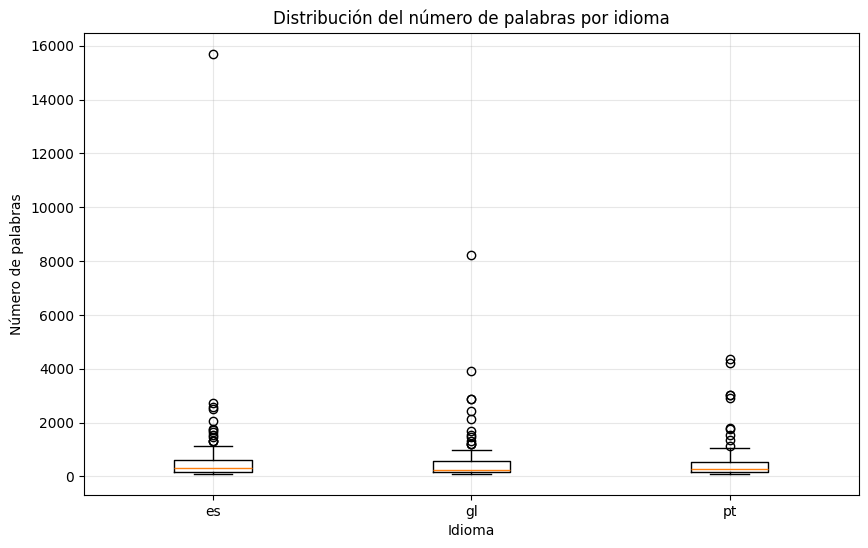

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([palabras_por_idioma[idioma] for idioma in idiomas],
            labels=idiomas)
plt.xlabel('Idioma')
plt.ylabel('Número de palabras')
plt.title('Distribución del número de palabras por idioma')
plt.grid(True, alpha=0.3)
plt.show()

Limpiar texto

In [ ]:
def limpiar_texto(t: str) -> str:
    t = t.lower()
    t = re.sub(r'[\x00-\x1f\x7f\xa0]+', ' ', t) #Caracteres muy raros en el texto
    t = re.sub(r'[\n\t\r\xa0]+', ' ', t)
    t = re.sub(r'\[\d+\]', ' ', t)               # referencias
    t = re.sub(r'[0-9]+', ' ', t)                # eliminar todos los números
    t = re.sub(
        r"[^a-záéíóúüñàèéêëîïôûùçœæÿãõ\s.,;:!?\'¡¿\-]",
        " ",
        t
    )
    t = " ".join(t.split())                       # quitar espacios múltiples
    return t

def char_ngrams_por_palabra(text, n_min=2, n_max=4):
    words = text.split()
    ngrams = []
    for w in words:
        for n in range(n_min, min(n_max+1, len(w)+1)):
            for i in range(len(w)-n+1):
                ngrams.append(w[i:i+n])
    return ngrams

In [ ]:
textos_es = textos['es']
textos_gl = textos['gl']
textos_pt = textos['pt']

Extraer N-gramas n=2,3,4

In [ ]:
texto_es_limp = [limpiar_texto(t) for t in textos_es]
textos_gl_limp = [limpiar_texto(t) for t in textos_gl]
textos_pt_limp = [limpiar_texto(t) for t in textos_pt]

In [ ]:
vect_es = CountVectorizer(analyzer="word", tokenizer=char_ngrams_por_palabra, token_pattern=None)
X_es = vect_es.fit_transform(texto_es_limp)

vect_gl = CountVectorizer(analyzer="word", tokenizer=char_ngrams_por_palabra, token_pattern=None)
X_gl = vect_gl.fit_transform(textos_gl_limp)

vect_pt = CountVectorizer(analyzer="word", tokenizer=char_ngrams_por_palabra, token_pattern=None)
X_pt = vect_pt.fit_transform(textos_pt_limp)

Perfiles de idioma

In [ ]:
ngrams_es = vect_es.get_feature_names_out()
ngrams_gl = vect_gl.get_feature_names_out()
ngrams_pt = vect_pt.get_feature_names_out()

In [ ]:
frecuencias_es = np.array(X_es.sum(axis=0)).flatten()
frecuencias_es_norm = frecuencias_es / frecuencias_es.sum()

frecuencias_gl = np.array(X_gl.sum(axis=0)).flatten()
frecuencias_gl_norm = frecuencias_gl / frecuencias_gl.sum()

frecuencias_pt = np.array(X_pt.sum(axis=0)).flatten()
frecuencias_pt_norm = frecuencias_pt / frecuencias_pt.sum()


In [ ]:
df_es = pd.DataFrame({'ngram': ngrams_es, 'es': frecuencias_es_norm})
df_gl = pd.DataFrame({'ngram': ngrams_gl, 'gl': frecuencias_gl_norm})
df_pt = pd.DataFrame({'ngram': ngrams_pt, 'pt': frecuencias_pt_norm})

In [ ]:
df_all = pd.merge(df_es, df_gl, on='ngram', how='outer')
df_all = pd.merge(df_all, df_pt, on='ngram', how='outer')
df_all = df_all.fillna(0)

In [ ]:
print(df_all.head(20))

   ngram        es        gl        pt
0     !'  0.000000  0.000000  0.000002
1     !,  0.000000  0.000002  0.000004
2     !.  0.000000  0.000002  0.000000
3     ',  0.000000  0.000000  0.000002
4     '.  0.000000  0.000002  0.000002
5     ':  0.000000  0.000002  0.000002
6     'a  0.000005  0.000007  0.000006
7    'ab  0.000000  0.000002  0.000000
8   'abd  0.000000  0.000002  0.000000
9    'al  0.000000  0.000002  0.000000
10  'alc  0.000000  0.000002  0.000000
11   'am  0.000000  0.000000  0.000002
12  'amp  0.000000  0.000000  0.000002
13   'an  0.000000  0.000002  0.000004
14  'ang  0.000000  0.000000  0.000004
15  'anm  0.000000  0.000002  0.000000
16   'ao  0.000000  0.000002  0.000000
17  'ao?  0.000000  0.000002  0.000000
18   'ar  0.000002  0.000000  0.000000
19  'arb  0.000002  0.000000  0.000000


Similitud coseno con los perfiles

In [ ]:
ngram_list = df_all['ngram'].tolist()

In [ ]:
perfil_es = df_all['es'].values.reshape(1, -1)
perfil_gl = df_all['gl'].values.reshape(1, -1)
perfil_pt  = df_all['pt'].values.reshape(1, -1)

In [ ]:
perfiles = np.vstack([perfil_es, perfil_gl, perfil_pt])
idiomas = ['es', 'gl', 'pt']

In [ ]:
def vectorizar_texto(texto, ngram_list):
    ngrams_texto = char_ngrams_por_palabra(limpiar_texto(texto))
    vec = np.zeros(len(ngram_list))

    ngram_to_idx = {ng: i for i, ng in enumerate(ngram_list)}

    for ng in ngrams_texto:
        if ng in ngram_to_idx:
            vec[ngram_to_idx[ng]] += 1

    if vec.sum() > 0:
        vec = vec / vec.sum()
    return vec.reshape(1, -1)

def clasificar_por_coseno(texto):
    vec_texto = vectorizar_texto(texto, ngram_list)
    sims = cosine_similarity(vec_texto, perfiles)
    idioma_predicho = idiomas[np.argmax(sims)]
    return idioma_predicho, sims.flatten()

In [ ]:
texto_nuevo = "La intelixencia artificial está mudando el mundo"
idioma, sims = clasificar_por_coseno(texto_nuevo)
print("Idioma predicho:", idioma)
print("Similitudes:", sims)

Idioma predicho: es
Similitudes: [0.36631642 0.35397466 0.33674144]


Modelos

In [ ]:
X_textos = textos_es + textos_gl + textos_pt
y = ['es']*len(textos_es) + ['gl']*len(textos_gl) + ['pt']*len(textos_pt)

In [ ]:
X_limpios = [limpiar_texto(t) for t in X_textos]

In [ ]:
vect = CountVectorizer(analyzer="word", tokenizer=char_ngrams_por_palabra, token_pattern=None, max_features=50)
X = vect.fit_transform(X_limpios)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

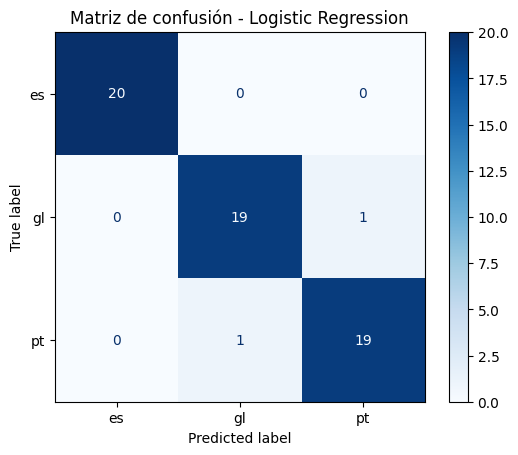

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression")
plt.show()

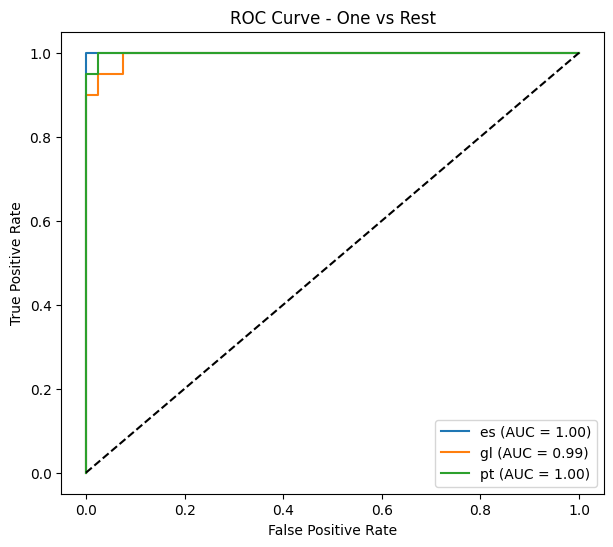

In [ ]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = lr.predict_proba(X_test)

plt.figure(figsize=(7, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One vs Rest")
plt.legend()
plt.show()


In [ ]:
coefficients = lr.coef_
coefficients_df = pd.DataFrame(coefficients, columns=vect.get_feature_names_out())
coefficients_df = coefficients_df.T
coefficients_df.columns = ['es', 'gl', 'pt']
coefficients_df = coefficients_df.sort_values(by='es', ascending=False)
coefficients_df.head()

,es,gl,pt
la,0.392569,-0.179337,-0.213231
en,0.310723,0.059813,-0.370536
el,0.208523,-0.176623,-0.031900
ci,0.161969,0.162720,-0.324689
un,0.137450,0.315281,-0.452731


In [ ]:
coefficients_df = coefficients_df.sort_values(by='gl', ascending=False)
coefficients_df.head()

,es,gl,pt
un,0.137450,0.315281,-0.452731
an,-0.107881,0.202490,-0.094609
po,-0.158632,0.178284,-0.019652
ci,0.161969,0.162720,-0.324689
st,-0.109661,0.143172,-0.033511


In [ ]:
coefficients_df = coefficients_df.sort_values(by='pt', ascending=False)
coefficients_df.head()

,es,gl,pt
em,0.007879,-0.552461,0.544582
ent,0.042458,-0.204655,0.162197
qu,-0.084534,-0.051799,0.136332
ra,-0.095914,-0.036019,0.131933
io,0.043661,-0.172509,0.128848


In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

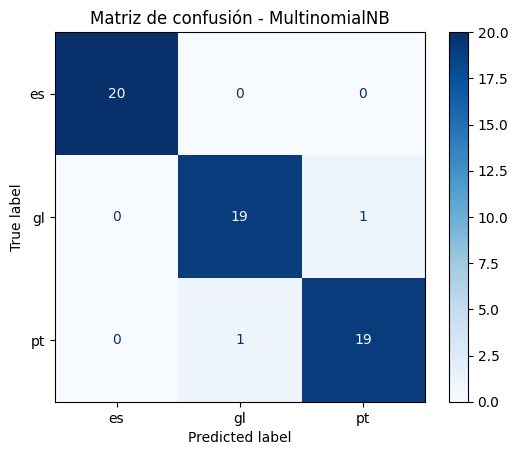

In [ ]:
ConfusionMatrixDisplay.from_estimator(mnb, X_test, y_test, cmap="Blues")
plt.title("Matriz de confusión - MultinomialNB")
plt.show()


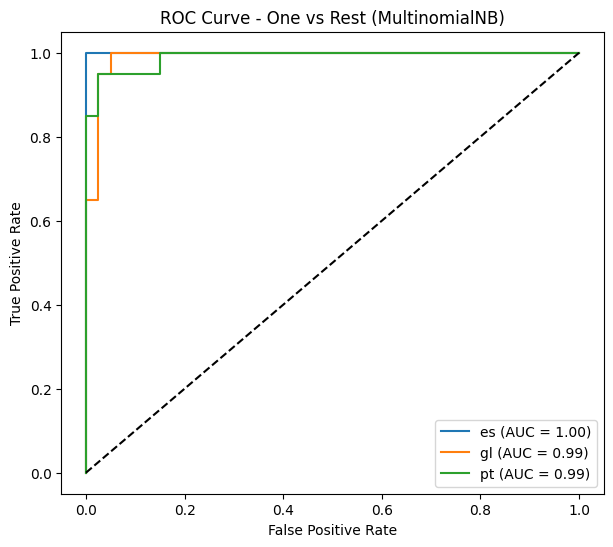

In [ ]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = mnb.predict_proba(X_test)

plt.figure(figsize=(7, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One vs Rest (MultinomialNB)")
plt.legend()
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

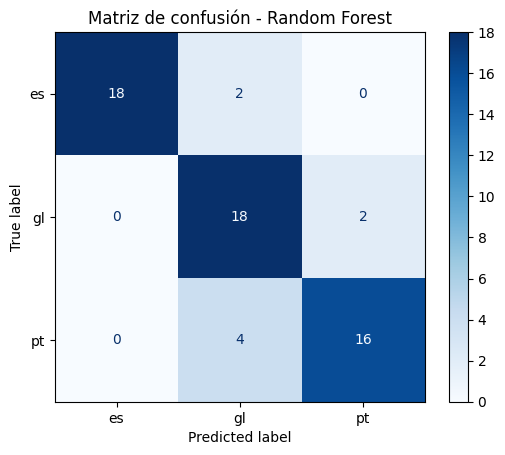

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Matriz de confusión - Random Forest")
plt.show()

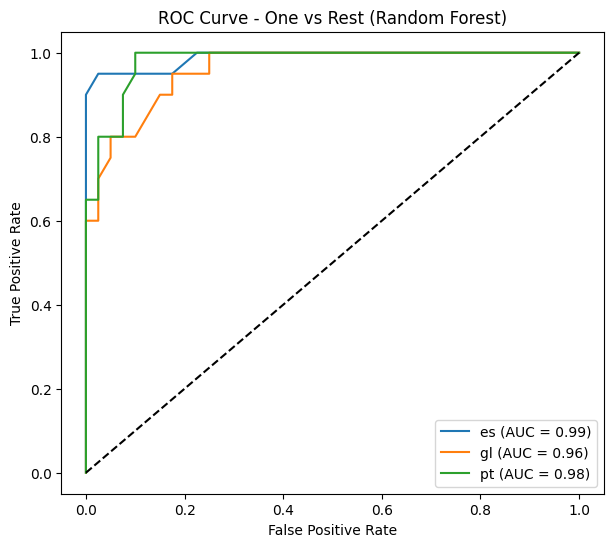

In [ ]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = rf.predict_proba(X_test)

plt.figure(figsize=(7, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One vs Rest (Random Forest)")
plt.legend()
plt.show()

In [ ]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

print("\nMultinomial Naive Bayes")
print(classification_report(y_test, y_pred_mnb))
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))

print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Logistic Regression
              precision    recall  f1-score   support

          es       1.00      1.00      1.00        20
          gl       0.95      0.95      0.95        20
          pt       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Accuracy: 0.9666666666666667

Multinomial Naive Bayes
              precision    recall  f1-score   support

          es       1.00      1.00      1.00        20
          gl       0.95      0.95      0.95        20
          pt       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Accuracy: 0.9666666666666667

Random Forest
              precision    recall  f1-score   support

          es       1.00      0.90      0.95        20
          g

In [ ]:
textos_prueba = [
    "ezta es una preba con mala escriitura y mal intencionada che vuestro",
    "La inteligencia artificial está cambiando el mundo",
    "A intelixencia artificial está cambiando o mundo",
    "A inteligência artificial está mudando o mundo",
    "La inteligencia artificial está cambiando el mundo a una velocidad sin precedentes, transformando desde la medicina hasta la educación y la manera en que nos comunicamos. Uno de los campos más impactados es el procesamiento de lenguaje natural, que permite a las máquinas comprender, generar y analizar el lenguaje humano. Gracias a estas tecnologías, hoy es posible traducir textos en tiempo real, crear asistentes virtuales inteligentes, detectar emociones en mensajes o incluso resumir grandes volúmenes de información de forma automática. Este avance no solo facilita la interacción entre personas y sistemas, sino que también abre la puerta a nuevas formas de innovación y colaboración global.",
    "A intelixencia artificial está cambiando o mundo a unha velocidade sen precedentes, transformando todo, desde a medicina ata a educación ata a forma en que nos comunicamos. Un dos campos máis afectados é o procesamento da linguaxe natural, que permite ás máquinas comprender, xerar e analizar a linguaxe humana. Grazas a estas tecnoloxías, agora é posible traducir textos en tempo real, crear asistentes virtuais intelixentes, detectar emocións nas mensaxes e mesmo resumir automaticamente grandes volumes de información. Este avance non só facilita a interacción entre as persoas e os sistemas, senón que tamén abre a porta a novas formas de innovación e colaboración global.",
    "A inteligência artificial está mudando o mundo a uma velocidade sem precedentes, transformando tudo, da medicina à educação e à forma como nos comunicamos. Um dos campos mais impactados é o processamento de linguagem natural, que permite que máquinas entendam, gerem e analisem a linguagem humana. Graças a essas tecnologias, agora é possível traduzir textos em tempo real, criar assistentes virtuais inteligentes, detectar emoções em mensagens e até mesmo resumir automaticamente grandes volumes de informações. Esse avanço não apenas facilita a interação entre pessoas e sistemas, mas também abre portas para novas formas de inovação e colaboração global."
]

idioma_textos_prueba = ["mx", "es", "gl", "pt", "es", "gl", "pt"]

# Limpiar los textos
textos_prueba_limp = [limpiar_texto(t) for t in textos_prueba]

# Transformar con CountVectorizer entrenado
X_prueba = vect.transform(textos_prueba_limp)

In [ ]:
# Logistic Regression
y_pred_lr = lr.predict(X_prueba)

# Multinomial Naive Bayes
y_pred_mnb = mnb.predict(X_prueba)

# Random Forest
y_pred_rf = rf.predict(X_prueba)


In [ ]:
print(f"Logistic Regression: \t{y_pred_lr}")
print(f"MultinomialNB: \t\t{y_pred_mnb}")
print(f"Random Forest: \t\t{y_pred_rf}")
print(f"Idioma correcto: \t{np.array(idioma_textos_prueba)}")

Logistic Regression: 	['es' 'es' 'gl' 'gl' 'es' 'gl' 'pt']
MultinomialNB: 		['es' 'es' 'es' 'gl' 'es' 'gl' 'pt']
Random Forest: 		['gl' 'gl' 'gl' 'gl' 'es' 'pt' 'pt']
Idioma correcto: 	['mx' 'es' 'gl' 'pt' 'es' 'gl' 'pt']


In [ ]:
ti = 0
for texto in textos_prueba:
    idioma, sims = clasificar_por_coseno(texto)
    print(f"Muestra: {texto}")
    print(f"Idioma correcto: \t{idioma_textos_prueba[ti]}")
    print(f"Preddión por coseno: \t{idioma}")
    print(f"Similitudes: \t\t{sims}\n")
    ti+=1

Muestra: ezta es una preba con mala escriitura y mal intencionada che vuestro
Idioma correcto: 	mx
Preddión por coseno: 	es
Similitudes: 		[0.44831646 0.42649408 0.41318404]

Muestra: La inteligencia artificial está cambiando el mundo
Idioma correcto: 	es
Preddión por coseno: 	es
Similitudes: 		[0.37707051 0.34957816 0.34177798]

Muestra: A intelixencia artificial está cambiando o mundo
Idioma correcto: 	gl
Preddión por coseno: 	gl
Similitudes: 		[0.34490094 0.34677379 0.32794352]

Muestra: A inteligência artificial está mudando o mundo
Idioma correcto: 	pt
Preddión por coseno: 	gl
Similitudes: 		[0.31173758 0.3224009  0.31421515]

Muestra: La inteligencia artificial está cambiando el mundo a una velocidad sin precedentes, transformando desde la medicina hasta la educación y la manera en que nos comunicamos. Uno de los campos más impactados es el procesamiento de lenguaje natural, que permite a las máquinas comprender, generar y analizar el lenguaje humano. Gracias a estas tecnologías,